## 수정사항
#### 2021.06.04
* Gripper 자유도 45도로 제한됨에 따라 파지점 방향 수정, 바닥 파지면은 삭제

## set running directory

In [1]:
from __future__ import print_function
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

In [2]:
from pkg.controller.combined_robot import *
from pkg.utils.utils import get_now, try_mkdir


DATA_PATH = os.path.join(os.environ['RNB_PLANNING_DIR'], "data")
try_mkdir(DATA_PATH)

ALG_DATA_PATH = os.path.join(DATA_PATH, "latticized")
try_mkdir(ALG_DATA_PATH)

In [3]:
VISUALIZE = False
TIMEOUT_REACH = 30
TIMEOUT_RETRIEVE = 30
TIMEOUT_SELF = 1
CLEARANCE = 1e-3

ROBOT_TYPE = RobotType.indy7
ROBOT_NAME = "indy0"
TOOL_LINK = "indy0_tcp"
TOOL_XYZ = (0,0,0.14)
TOOL_RPY = (-np.pi/2,0,0)
GRIP_DEPTH = 0.05
HOME_POSE = (0,0,0,0,0,0)

# ROBOT_TYPE = RobotType.panda
# ROBOT_NAME = "panda0"
# TOOL_LINK = "panda0_hand"
# TOOL_XYZ = (0,0,0.112)
# TOOL_RPY = (-np.pi/2,0,0)
# GRIP_DEPTH = 0.03
# HOME_POSE = (0,-0.3,0,-0.5,0,2.5,0)

## init combined robot config

In [4]:

from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, ROBOT_TYPE, None,
                INDY_IP)]
              , connection_list=[False])

from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

connection command:
indy0: False


## get ghnd with detected robot config

In [5]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {ROBOT_NAME: ((0,0,0), (0,0,0))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob, start_rviz=VISUALIZE)
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


In [6]:
from pkg.utils.joint_utils import get_tf
shoulder_link = gscene.urdf_content.joint_map[gscene.joint_names[1]].child
shoulder_height = get_tf(shoulder_link, HOME_DICT, gscene.urdf_content)[2,3]

## add environment

In [7]:
from pkg.geometry.geometry import *
gtems_robot = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)

## init planning scene

In [8]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

## Register binders

In [9]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepTool

In [10]:
gscene.create_safe(gtype=GEOTYPE.SPHERE, name="grip0", link_name=TOOL_LINK, 
                 dims=(0.01,)*3, center=TOOL_XYZ, rpy=TOOL_RPY, color=(1,0,0,1), display=True, collision=False, fixed=True)
gripper = pscene.create_binder(bname="grip0", gname="grip0", _type=Gripper2Tool)

## ui

In [11]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


# Object Classes

In [12]:
from pkg.utils.gjk import get_point_list, get_gjk_distance
from pkg.planning.constraint.constraint_subject import CustomObject, Grasp2Point, PlacePoint, SweepPoint, SweepTask

##
# @class ObstacleBase
# @brief base class for obstacle generators
class ObstacleBase:
    RTH_MIN = None ## R: center ~ nearest point
    RTH_MAX = None
    RPY_MIN = None
    RPY_MAX = None
    DIM_MIN = None
    DIM_MAX = None
    GTYPE = None
    COLOR = (0.7,0.7,0.7,1)
    
    def __init__(self, gscene, name, sampler=np.random.uniform, DIM=None, RTH=None, RPY=None):
        self.name = name
        self.DIM = sampler(self.DIM_MIN, self.DIM_MAX) if DIM is None else DIM
        self.RTH = sampler(self.RTH_MIN, self.RTH_MAX) if RTH is None else RTH
        self.RPY = sampler(self.RPY_MIN, self.RPY_MAX) if RPY is None else RPY
        self.RPY[2] += self.RTH[1]
        self.XYZ = np.array(cyl2cart(*self.RTH))
        verts_rotated = np.matmul(Rot_rpy(self.RPY), (DEFAULT_VERT_DICT[self.GTYPE]*self.DIM).transpose())
        xy_normed = self.XYZ[:2]/(np.linalg.norm(self.XYZ[:2])+1e-6)
        verts_r_compo = np.dot(xy_normed, verts_rotated[:2,:])
        self.XYZ[:2] -= xy_normed[:2]*np.min(verts_r_compo)
        self.RTH[0] -= np.min(verts_r_compo)
        self.geometry = gscene.create_safe(gtype=self.GTYPE, name=self.name, link_name="base_link", 
                                  dims=self.DIM, center=tuple(self.XYZ), rpy=self.RPY, 
                                  color=self.COLOR, display=True, collision=True, fixed=True)
        self.subgeo_list = []
        
    def is_overlapped_with(self, gtem):
        verts, radii = gtem.get_vertice_radius()
        verts_global = np.add(np.matmul(verts, gtem.orientation_mat.transpose()), gtem.center)
        verts_me, raddii_me = self.geometry.get_vertice_radius()
        verts_me_global = np.add(np.matmul(verts_me, self.geometry.orientation_mat.transpose()), 
                                 self.geometry.center)
        return get_gjk_distance(get_point_list(verts_global), get_point_list(verts_me_global))-radii-raddii_me < 1e-4
        
##
# @class WorkPlane
# @brief working plane. target and obstacle objects are generated on this plane
class WorkPlane(ObstacleBase):
    RTH_MIN = (0.3, -np.pi/2, -0.2)
    RTH_MAX = (0.8, +np.pi/2, +0.5)
    RPY_MIN = (0, 0, -np.pi/6)
    RPY_MAX = (0, 0, +np.pi/6)
    DIM_MIN = (0.3, 0.3, 0.05)
    DIM_MAX = (0.8, 1.5, 0.1)
    GTYPE = GEOTYPE.BOX
    COLOR=  (0.8,0.8,0.2,0.5)
    
    def __init__(self, gscene, name, floor_height=None, *args, **kwargs):
        assert floor_height is not None, "floor_height needed"
        self.RTH_MIN = self.RTH_MIN[:2]+(floor_height,)
        self.H = 0.3
        ObstacleBase.__init__(self, gscene, name, *args, **kwargs)
        
    def is_overlapped_with(self, gtem):
        verts, radii = gtem.get_vertice_radius()
        verts_global = np.add(np.matmul(verts, gtem.orientation_mat.transpose()), gtem.center)
        verts_wp = np.multiply(DEFAULT_VERT_DICT[self.GTYPE], tuple(self.DIM[:2])+(self.H,))
        verts_wp_global = np.add(np.matmul(verts_wp, self.geometry.orientation_mat.transpose()), 
                                 np.add(self.geometry.center, (0,0,self.H/2)))
        return get_gjk_distance(get_point_list(verts_global), get_point_list(verts_wp_global))-radii < 1e-4
        
    
##
# @class Box
# @brief box with the top and the front side open
class Box(WorkPlane):
    RPY_MIN = (0, 0, -np.pi/2)
    RPY_MAX = (0, 0, +np.pi/2)
    DIM_MIN = (0.3, 0.3, 0.05)
    DIM_MAX = (0.6, 0.6, 0.05)
    COLOR =  (0.8,0.8,0.2,0.5)
    H_RANGE = (0.3, 0.6)
    THICKNESS = 0.05
    def __init__(self, gscene, name, H=None, **kwargs):
        WorkPlane.__init__(self, gscene=gscene, name=name, **kwargs)
        self.H = np.random.uniform(*self.H_RANGE) if H is None else H

        ## back wall
        self.subgeo_list.append(gscene.create_safe(
            gtype=self.GTYPE, name=self.name+"_bw", link_name="base_link", 
            dims=(self.THICKNESS, self.DIM[1], self.H), center=(self.DIM[0]/2+self.THICKNESS/2, 0,self.H/2), rpy=(0,0,0),
            color=self.COLOR, display=True, collision=True, fixed=True,
            parent=self.name))

        ## left wall
        self.subgeo_list.append(gscene.create_safe(
            gtype=self.GTYPE, name=self.name+"_lw", link_name="base_link", 
            dims=(self.DIM[0], self.THICKNESS, self.H), center=(0, -self.DIM[1]/2-self.THICKNESS/2, self.H/2), rpy=(0,0,0),
            color=self.COLOR, display=True, collision=True, fixed=True,
            parent=self.name))

        ## right wall
        self.subgeo_list.append(gscene.create_safe(
            gtype=self.GTYPE, name=self.name+"_rw", link_name="base_link", 
            dims=(self.DIM[0], self.THICKNESS, self.H), center=(0, self.DIM[1]/2+self.THICKNESS/2, self.H/2), rpy=(0,0,0),
            color=self.COLOR, display=True, collision=True, fixed=True,
            parent=self.name))

        
##
# @class SideBox
# @brief box with a side face open
class SideBox(Box):
    H_RANGE = (0.3, 0.6)
    def __init__(self, gscene, name, **kwargs):
        Box.__init__(self, gscene=gscene, name=name, **kwargs)

        ## top
        self.subgeo_list.append(gscene.create_safe(
            gtype=self.GTYPE, name=self.name+"_tp", link_name="base_link", 
            dims=(self.DIM[0], self.DIM[1], self.THICKNESS), center=(0, 0, self.H+self.THICKNESS/2), rpy=(0,0,0),
            color=self.COLOR, display=True, collision=True, fixed=True,
            parent=self.name))

##
# @class TopBox
# @brief box with the top face open
class TopBox(Box):
    DIM_MIN = (0.3, 0.3, 0.05)
    DIM_MAX = (0.6, 0.6, 0.05)
    H_RANGE = (0.3, 0.6)
    def __init__(self, gscene, name, **kwargs):
        Box.__init__(self, gscene=gscene, name=name, **kwargs)

        ## front wall
        self.subgeo_list.append(gscene.create_safe(
            gtype=self.GTYPE, name=self.name+"_fw", link_name="base_link", 
            dims=(self.THICKNESS, self.DIM[1], self.H), center=(-self.DIM[0]/2-self.THICKNESS/2, 0,self.H/2), rpy=(0,0,0),
            color=self.COLOR, display=True, collision=True, fixed=True,
            parent=self.name))
        
##
# @class Floor
# @brief Floor - lowerbound of the workspace
class Floor(ObstacleBase):
    RTH_MIN = (0.0, 0, -0.5)
    RTH_MAX = (0.0, 0, +0.0)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (3, 3, 0.1)
    DIM_MAX = (3, 3, 0.1)
    GTYPE = GEOTYPE.BOX
    
##
# @class Ceiling
# @brief Ceiling - upperbound of the workspace
class Ceiling(ObstacleBase):
    RTH_MIN = (0.0, 0, 1.0)
    RTH_MAX = (0.0, 0, 2)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (3, 3, 0.1)
    DIM_MAX = (3, 3, 0.1)
    GTYPE = GEOTYPE.BOX
    COLOR=  (0.7,0.7,0.7,0.5)
    
##
# @class Wall
# @brief define horizontal boundary of the workspace
class Wall(ObstacleBase):
    RTH_MIN = (0.3, -np.pi, 0)
    RTH_MAX = (2.0, np.pi, 0)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (0.1, 6, 3)
    DIM_MAX = (0.1, 6, 3)
    GTYPE = GEOTYPE.BOX
    COLOR=  (0.7,0.7,0.7,0.5)
    
##
# @class Pole
# @brief occasional poles that obstruct robot motion
class Pole(ObstacleBase):
    RTH_MIN = (0.3, -np.pi, 0)
    RTH_MAX = (0.8, +np.pi, 0)
    RPY_MIN = (0, 0, -np.pi/6)
    RPY_MAX = (0, 0, +np.pi/6)
    DIM_MIN = (0.1, 0.1, 4)
    DIM_MAX = (0.3, 0.3, 4)
    GTYPE = GEOTYPE.BOX
    COLOR = (0.7,0.7,0.7,0.3)
    
##
# @class Bar
# @brief occasional poles that obstruct robot motion
class Bar(ObstacleBase):
    RTH_MIN = (0.3, -np.pi, 0)
    RTH_MAX = (0.8, +np.pi, 1.5)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (0.1, 4, 0.1)
    DIM_MAX = (0.3, 4, 0.3)
    GTYPE = GEOTYPE.BOX
    COLOR = (0.7,0.7,0.7,0.3)
    
##
# @class PlaneObstacle
# @brief Obstacles on the workplane
class PlaneObject(ObstacleBase):
    RTH_MIN = (0.3, -np.pi/2, -0.2)
    RTH_MAX = (0.8, +np.pi/2, +0.5)
    RPY_MIN = (0, 0, -np.pi)
    RPY_MAX = (0, 0, +np.pi)
    DIM_MIN = (0.02, GRIP_DEPTH, GRIP_DEPTH)
    DIM_MAX = (0.06, 0.3, 0.3)
    GTYPE = GEOTYPE.BOX
    COLOR =  (0.2,0.2,0.8,0.5)
    def __init__(self, gscene, name, workplane, XYZ_LOC=None, **kwargs):
        ObstacleBase.__init__(self, gscene=gscene, name=name, **kwargs)
        verts, radii = self.geometry.get_vertice_radius()
        verts_rot = np.matmul(self.geometry.orientation_mat, verts.transpose()) ## verices with global orientaion
        verts_rot_loc = np.matmul(workplane.geometry.Toff[:3,:3].transpose(), verts_rot) ## verices with local orientaion
        max_verts = np.max(verts_rot_loc, axis=-1)
        min_verts = np.min(verts_rot_loc, axis=-1)
        if XYZ_LOC is None:
            self.XYZ_LOC = np.random.uniform(np.negative(workplane.DIM)/2-min_verts+radii,np.array(workplane.DIM)/2-max_verts-radii)
            self.XYZ_LOC[2] = workplane.DIM[2]/2 + self.DIM[2]/2 + CLEARANCE
        else:
            self.XYZ_LOC = self.XYZ_LOC
        self.XYZ = np.matmul(workplane.geometry.Toff[:3,:3], self.XYZ_LOC) + workplane.geometry.Toff[:3,3]
        self.geometry.set_offset_tf(center = self.XYZ)
        self.RTH = cart2cyl(*self.XYZ)
        gscene.update_marker(self.geometry)
        
        
def clear_class(gscene, key, Nmax):
    for iw in range(Nmax):
        gname = "{}_{}".format(key, iw)
        if gname in gscene.NAME_DICT:
            gscene.remove(gscene.NAME_DICT[gname])

            
def redistribute_class(gscene, obstacle_class, key, Nmax, workplane_avoid=None):
    clear_class(gscene, key, Nmax)
        
    obs_list = []
    for iw in range(np.random.choice(Nmax)):
        obs = obstacle_class(gscene, "{}_{}".format(key, iw))
        while workplane_avoid is not None and workplane_avoid.is_overlapped_with(obs.geometry):
            obs = obstacle_class(gscene, "{}_{}".format(key, iw))
        obs_list.append(obs)
    return obs_list

            
def disperse_objects(gscene, object_class, key, Nmax, workplane_on):
    clear_class(gscene, key, Nmax)
        
    obs_list = []
    for iw in range(np.random.choice(Nmax)+1):
        obs = object_class(gscene, "{}_{}".format(key, iw), workplane_on)
        remove_this = False
        for obs_pre in obs_list:
            if obs_pre.is_overlapped_with(obs.geometry):
                remove_this = True
                break
        if remove_this:
            gscene.remove(obs.geometry)
        else:
            obs_list.append(obs)
    return obs_list


def add_object(pscene, obj, HANDLE_THICKNESS=1e-6, HANDLE_COLOR = (1,0,0,0.3)):
    gscene = pscene.gscene
    handles = []
    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_a", link_name="base_link", 
                       dims=(obj.DIM[1], GRIP_DEPTH, HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(np.pi/2,0,np.pi/2), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_b", link_name="base_link", 
                       dims=(obj.DIM[1], GRIP_DEPTH, HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(np.pi/2,0,-np.pi/2), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,-np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(-np.pi,-np.pi/2,0), 
                       color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                   parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(-np.pi,+np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    action_points_dict = {"placement": PlacePoint("placement", obj.geometry, [0,0,-obj.DIM[2]/2], [0,0,0])}
    action_points_dict.update({handle.name: Grasp2Point(handle.name, handle, None, (0,0,0)) for handle in handles})
    obj_pscene = pscene.create_subject(oname=obj.name, gname=obj.name, _type=CustomObject, 
                                 action_points_dict=action_points_dict)
    return obj_pscene, handles
        
WORKPLANE_TYPES = [WorkPlane, Box, SideBox, TopBox]

Nmax_wall, Nmax_pole, Nmax_bar = 4, 8, 8

Nmax_obj = 3

### counting step-wise

In [13]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker
gcheck = GraspChecker(pscene)
rcheck = ReachChecker(pscene)
lcheck = LatticedChecker(pscene, gcheck=gcheck)
gchecker = MoveitPlanner(pscene, motion_filters=[gcheck])
rchecker = MoveitPlanner(pscene, motion_filters=[rcheck])
lchecker = MoveitPlanner(pscene, motion_filters=[lcheck])
checkers = [("GraspChecker", gchecker), ("ReachChecker", rchecker), ("LatticedChecker", lchecker)]

kchecker = MoveitPlanner(pscene)
mplan = MoveitPlanner(pscene)

In [ ]:
gtimer = GlobalTimer.instance()
gtimer.reset()
mplan.reset_log(True)

reach_success_list = []
retrieve_success_list = []
reach_time_list = []
retrieve_time_list = []
ik_time_list = []

sample_count = 0
count_max = 5000

N_print = 50

gtimer.tic("full_loop")

i_print = 0
check_dict = defaultdict(list)
check_time_dict = defaultdict(list)
while sample_count < count_max:
    ## add floor, ceiling
    floor = Floor(gscene, "floor")
    # ceiling = Ceiling(gscene, "ceiling")

    ## set workplane
    wp = random.choice(WORKPLANE_TYPES)(gscene, "wp", floor_height=floor.RTH[2]+floor.DIM[2]/2)
    pscene.create_binder(bname="wp", gname="wp", _type=PlacePlane)

    ## add walls, poles, bars
    walls = redistribute_class(gscene, Wall, "wl", Nmax_wall, workplane_avoid=wp)
    poles = redistribute_class(gscene, Pole, "po", Nmax_pole, workplane_avoid=wp)
    bars = redistribute_class(gscene, Bar, "bar", Nmax_bar, workplane_avoid=wp)

    ## add object
    obj_list = disperse_objects(gscene, PlaneObject, "obj", Nmax_obj, workplane_on=wp)

    samples = []
    for obj in obj_list:
        SHOW_PERIOD = 0.01
        N_sample_single_obj = 3
        obj_pscene, handles = add_object(pscene, obj)
        mplan.update_gscene()
        initial_state = pscene.initialize_state(HOME_POSE)
        pscene.set_object_state(initial_state)
        to_node = ("grip0",)
        available_binding_dict = pscene.get_available_binding_dict(initial_state, to_node, HOME_DICT)
        samples_obj = []
        for _ in range(N_sample_single_obj):
            from_state = initial_state.copy(pscene)
            to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
            pscene.set_object_state(from_state)
            res = True
            res_col = False
            res_reach = False
            for cname, checker in checkers:
                gtimer.tic(cname)
                res = checker.plan_transition(
                    from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, test_filters_only=True)
                ctime = gtimer.toc(cname)
                check_dict[cname].append(res)
                check_time_dict[cname].append(ctime)
                if cname == "GraspChecker":
                    res_col = res
                if cname == "ReachChecker":
                    res_reach = res
                if not res:
                    break
                   
            if res_col:
                gtimer.tic("ik")
                Traj_kin, LastQ, error, success_kin, binding_list = kchecker.plan_transition(
                    from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, 
                    only_self_collision=True, timeout=TIMEOUT_SELF)
                time_ik = gtimer.toc("ik")
                check_dict["inv_kin"].append(success_kin)
                if success_kin:
                    ik_time_list.append(time_ik)
            else:
                success_kin = False

            success_reach, success_retrieve = False, False
            time_reach, time_retrieve = TIMEOUT_REACH, TIMEOUT_RETRIEVE
            if res_reach or success_kin:
                if success_kin and not res_reach:
                    post_fix = "_ffkin"
                else:
                    post_fix = ""
                
                gtimer.tic("reach")
                Traj_reach, LastQ, error, success_reach, binding_list = mplan.plan_transition(
                    from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
                time_reach = gtimer.toc("reach")
                reach_success_list.append(success_reach)
    #             print("reach: {}".format(success_reach))
                Traj_retrieve = []
                if success_reach:
                    reach_time_list.append(time_reach)
                    if VISUALIZE:
                        gscene.show_motion(Traj_reach, period=SHOW_PERIOD)
                    for bd in binding_list:
                        pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                    binding_state, state_param = pscene.get_object_state()
                    new_state = State(binding_state, state_param, list(LastQ), pscene)
                    end_state = new_state.copy(pscene)
                    end_state.Q = np.array(HOME_POSE)
                    gtimer.tic("retrieve")
                    Traj_retrieve, LastQ, error, success_retrieve, binding_list = mplan.plan_transition(
                        from_state=new_state, to_state=end_state, timeout=TIMEOUT_RETRIEVE)
                    time_retrieve = gtimer.toc("retrieve")
                    retrieve_success_list.append(success_retrieve)
                    if success_retrieve:
                        retrieve_time_list.append(time_retrieve)
    #                 print("retrieve: {}".format(success_retrieve))
                    if success_retrieve and VISUALIZE:
                        gscene.show_motion(Traj_retrieve, period=SHOW_PERIOD)
                samples_obj.append((obj.name, from_state, to_state, redundancy_dict, 
                                    success_reach, success_retrieve, Traj_reach, Traj_retrieve, time_reach, time_retrieve))
                check_dict["planning"+post_fix].append(success_retrieve)
            else:
                pass
            
            if success_retrieve and not res_col:
                raise(RuntimeError("Something's wrong: successful motion but collision checker failed"))
    #             print("no save?")
            sample_count += 1
                    
            if sample_count % N_print == 0:
                print(" "+"="*20)
                print(" count: {} / {}".format(sample_count, count_max))
                print(" "+"-"*40)
                for k, v in check_dict.items():
                    print("                      \t {} / {}".format(np.sum(v), len(v)), end="\r")
                    print(" {} :".format(k))
                print(" "+"-"*40)
                print(" "+"="*20)
                
            if sample_count >= count_max:
                break
                
        samples = samples+samples_obj
        pscene.set_object_state(initial_state)

        pscene.remove_subject(obj_pscene.oname)
        for handle in handles:
            gscene.remove(handle)    

        gscene.update_markers_all()
        if sample_count >= count_max:
            break
    if sample_count >= count_max:
        break


print("")
print("")
print("============= Finished =================")
print(" "+"="*20)
print(" count: {} / {}".format(sample_count, count_max))
print(" "+"-"*40)
for k, v in check_dict.items():
    print("                      \t {} / {}".format(np.sum(v), len(v)), end="\r")
    print(" {} :".format(k))
print(" "+"-"*40)
print(" "+"="*20)

 count: 50 / 5000
 ----------------------------------------
 LatticedChecker :    	 4 / 4
 GraspChecker :       	 11 / 50
 planning :           	 3 / 4
 inv_kin :            	 4 / 11
 ReachChecker :       	 4 / 11
 ----------------------------------------
 count: 100 / 5000
 ----------------------------------------
 LatticedChecker :    	 9 / 10
 GraspChecker :       	 27 / 100
 planning :           	 7 / 10
 inv_kin :            	 10 / 27
 ReachChecker :       	 10 / 27
 ----------------------------------------
 count: 150 / 5000
 ----------------------------------------
 LatticedChecker :    	 10 / 13
 GraspChecker :       	 37 / 150
 planning :           	 7 / 13
 inv_kin :            	 13 / 37
 ReachChecker :       	 13 / 37
 ----------------------------------------
 count: 200 / 5000
 ----------------------------------------
 LatticedChecker :    	 10 / 13
 GraspChecker :       	 46 / 200
 planning :           	 7 / 13
 inv_kin :            	 13 / 46
 ReachChecker :       	 13 / 4

name 	 	 	 min   	 median 	 mean 	 max (ms)
GraspChecker   : 	 0.82  	 1.4 	 1.79 	 6.66
ReachChecker   : 	 0.47  	 0.55 	 0.74 	 1.96
LatticedChecker   : 	 30.51  	 47.18 	 47.49 	 86.89


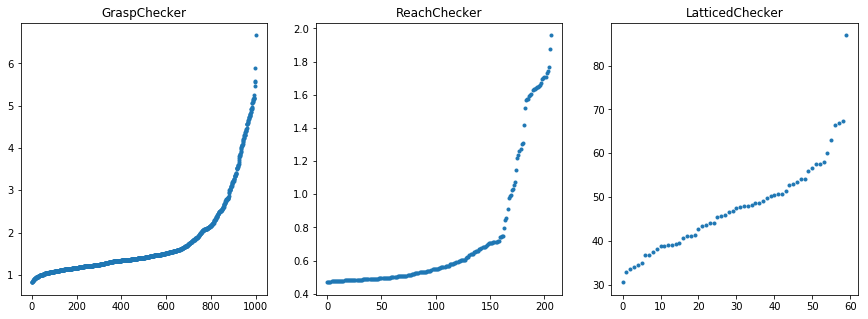

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
print("name \t \t \t min   \t median \t mean \t max (ms)")
for i_c, (cname, checker) in enumerate(checkers):
    plt.subplot(1,len(checkers), i_c+1)
    times =check_time_dict[cname]
    plt.plot(sorted(times), '.')
    plt.title(cname)
    print("{}   : \t {}  \t {} \t {} \t {}".format(cname, 
                                          np.round(np.min(times), 2), 
                                          np.round(np.median(times), 2), 
                                          np.round(np.mean(times), 2), 
                                          np.round(np.max(times), 2)))

name 	 	 min   	 median 	 mean 	 max (ms)
Inv. Kin.  	 : 	 24.59  	 46.56 	 47.02 	 71.74
Reach  	 : 	 45.62  	 125.1 	 230.94 	 1209.24
Retrieve  	 : 	 45.62  	 125.1 	 230.94 	 1209.24


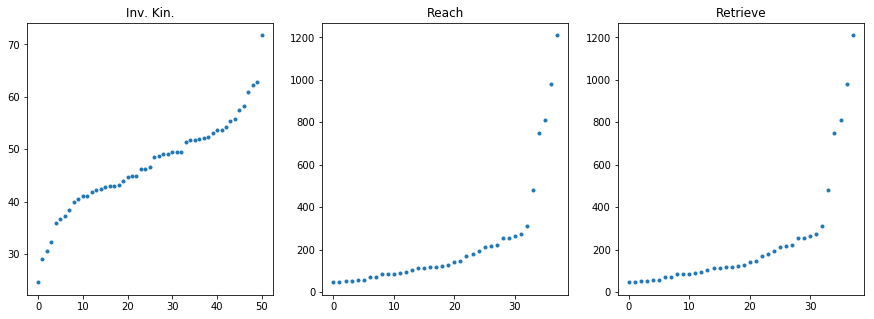

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
print("name \t \t min   \t median \t mean \t max (ms)")
for i_c, (tname, timelist) in enumerate(
                                                        zip(
                                                            ["Inv. Kin.", "Reach", "Retrieve"], 
                                                            [ik_time_list, retrieve_time_list, retrieve_time_list]
                                                        )):
    plt.subplot(1,3, i_c+1)
    plt.plot(sorted(timelist), '.')
    plt.title(tname)
    print("{}  \t : \t {}  \t {} \t {} \t {}".format(tname, 
                                          np.round(np.min(timelist), 2), 
                                          np.round(np.median(timelist), 2), 
                                          np.round(np.mean(timelist), 2), 
                                          np.round(np.max(timelist), 2)))

In [ ]:
def print_confusion_mat(GT, Res):
    TP = np.sum(np.logical_and(GT, Res))
    FN = np.sum(np.logical_and(GT, np.logical_not(Res)))
    FP = np.sum(np.logical_and(np.logical_not(GT), Res))
    TN = np.sum(np.logical_and(np.logical_not(GT), np.logical_not(Res)))
    N = TP+FN+FP+TN
    print("\t PP \t \t PN \t \t {}".format(N))
    print("GP \t {} \t \t {} \t \t {:.2%}".format(TP, FN, float(TP)/(TP+FN)))
    print("GN \t {} \t \t {} \t {:.2%}".format(FP, TN, float(TN)/(FP+TN)))
    print("AL \t {:.2%} \t {:.2%} \t {:.2%}".format(float(TP)/(TP+FP), float(TN)/(TN+FN), float(TP+TN)/N))

In [44]:
TOT = len(check_dict['GraspChecker'])

Gres = np.copy(check_dict['GraspChecker'])

Rres = np.copy(Gres)
Rres[np.where(Gres)] = check_dict['ReachChecker']
Rgt = np.copy(Gres)
Rgt[np.where(Gres)] = check_dict['inv_kin']

Lres = np.copy(Rres)
Lres[np.where(Rres)] = check_dict['LatticedChecker']
Lgt = np.logical_or(Rres, Rgt)
Lgt[np.where(Lgt)] = check_dict['planning']

print("="*10+" ReachChecker "+"="*10)
print_confusion_mat(GT=Rgt[np.where(Gres)], Res=Rres[np.where(Gres)])
print("="*30)
      
print("="*10+" LatticedChecker "+"="*10)
print_confusion_mat(GT=Lgt[np.where(Rres)], Res=Lres[np.where(Rres)])
print("="*30)
      
print("="*10+" GraspReach "+"="*10)
print_confusion_mat(GT=Rgt, Res=Rres)
print("="*30)
      
print("="*10+" ReachTotal "+"="*10)
print_confusion_mat(GT=Lgt, Res=Rres)
print("="*30)
      
print("="*10+" Total "+"="*10)
print_confusion_mat(GT=Lgt, Res=Lres)
print("="*30)

========== ReachChecker ==========
	 PP 	 	 PN 	 	 207
GP 	 51 	 	 0 	 	 100.00%
GN 	 9 	 	 147 	 94.23%
AL 	 85.00% 	 100.00% 	 95.65%
========== LatticedChecker ==========
	 PP 	 	 PN 	 	 60
GP 	 37 	 	 1 	 	 97.37%
GN 	 12 	 	 10 	  	 45.45%
AL 	 75.51% 	 90.91% 	 78.33%
========== GraspReach ==========
	 PP 	 	 PN 	 	 1000
GP 	 51 	 	 0 	 	 100.00%
GN 	 9 	 	 940 	 99.05%
AL 	 85.00% 	 100.00% 	 99.10%
========== ReachTotal ==========
	 PP 	 	 PN 	 	 1000
GP 	 38 	 	 0 	 	 100.00%
GN 	 22 	 	 940 	 97.71%
AL 	 63.33% 	 100.00% 	 97.80%
========== Total ==========
	 PP 	 	 PN 	 	 1000
GP 	 37 	 	 1 	 	 97.37%
GN 	 12 	 	 950 	 98.75%
AL 	 75.51% 	 99.89% 	 98.70%


### Indy7
```
    ========== ReachChecker ==========
         PP 	 	 PN 	 	 207
    GP 	 51 	 	 0 	 	 100.00%
    GN 	 9 	 	 147 	 94.23%
    AL 	 85.00% 	 100.00% 	 95.65%
    ==============================
    ========== LatticedChecker ==========
         PP 	 	 PN 	 	 60
    GP 	 37 	 	 1 	 	 97.37%
    GN 	 12 	 	 10 	  	 45.45%
    AL 	 75.51% 	 90.91% 	 78.33%
    ==============================
    ========== GraspReach ==========
         PP 	 	 PN 	 	 1000
    GP 	 51 	 	 0 	 	 100.00%
    GN 	 9 	 	 940 	 99.05%
    AL 	 85.00% 	 100.00% 	 99.10%
    ==============================
    ========== ReachTotal ==========
         PP 	 	 PN 	 	 1000
    GP 	 38 	 	 0 	 	 100.00%
    GN 	 22 	 	 940 	 97.71%
    AL 	 63.33% 	 100.00% 	 97.80%
    ==============================
    ========== Total ==========
         PP 	 	 PN 	 	 1000
    GP 	 37 	 	 1 	 	 97.37%
    GN 	 12 	 	 950 	 98.75%
    AL 	 75.51% 	 99.89% 	 98.70%
    ==============================
```

In [43]:
print(" "+"="*20)
print(" count: {} / {}".format(sample_count, count_max))
print(" "+"-"*40)
for k, v in check_dict.items():
    print("                      \t {} / {}".format(np.sum(v), len(v)), end="\r")
    print(" {} :".format(k))
print(" "+"-"*40)
print(" "+"="*20)

 count: 1000 / 1000
 ----------------------------------------
 LatticedChecker :
 GraspChecker :
 planning :
 inv_kin :
 ReachChecker :
 ----------------------------------------


#### filter counts
* Indy7
```
 ====================
 count: 1000/ 1000
 ----------------------------------------
 GraspChecker: 226/1002
 planning: 47/73
 ReachChecker: 73/226
 ik_gt: 63/226
 ====================
```

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.array(reach_time_list)[np.where(reach_success_list)], '.')
plt.plot(np.array(retrieve_time_list)[np.where(retrieve_success_list)], '.')
# plt.axis([0, 400, 0, 30000])

In [ ]:
idx_succ = np.where(retrieve_success_list)[0]
retrieve_success_only=np.array(retrieve_time_list)[idx_succ]

In [ ]:
np.sqrt(np.sum(np.square(retrieve_success_only))/len(retrieve_success_only))

In [ ]:
pp = plt.hist(retrieve_success_only, bins=10)

In [34]:
len(np.where(retrieve_success_only>20000)[0])

13

In [35]:
len(retrieve_success_only)

3426

### Resetting SharedArray

In [5]:
import SharedArray as sa
import numpy as np
import time
robot_type_name = 'indy7'
sa.delete("shm://{}.grasp_img".format(robot_type_name))
sa.delete("shm://{}.arm_img".format(robot_type_name))
sa.delete("shm://{}.rh_vals".format(robot_type_name))
sa.delete("shm://{}.result".format(robot_type_name))
sa.delete("shm://{}.query_in".format(robot_type_name))
sa.delete("shm://{}.response_out".format(robot_type_name))
sa.delete("shm://{}.query_quit".format(robot_type_name))

## ====================== deprecated ============================

## prepare cells

In [ ]:
gtimer = GlobalTimer.instance()
gtimer.reset()
with gtimer.block("prepare_reference_cells_ltc_full"):
    ltc_full.prepare_reference_cells(gscene)
with gtimer.block("prepare_reference_cells_ltc_effector"):
    ltc_effector.prepare_reference_cells(gscene)
with gtimer.block("prepare_reference_cells_ltc_arm_05"):
    ltc_arm_05.prepare_reference_cells(gscene)
with gtimer.block("prepare_reference_cells_ltc_arm_10"):
    ltc_arm_10.prepare_reference_cells(gscene)
print(gtimer)

In [ ]:
gscene.show_motion(Traj_reach)

## visualize

In [ ]:
vistem_list = []
for col_idx in grasp_dict['tar']:
    vistem_list.append(gscene.copy_from(ltc_effector.cell_refs[col_idx], color=(0,0,1,0.3)))

for col_idx in grasp_dict['tool']:
    vistem_list.append(gscene.copy_from(ltc_effector.cell_refs[col_idx], color=(0,1,0,0.3)))

In [ ]:
for vistem in vistem_list:
    if vistem in gscene:
        gscene.remove(vistem)

In [ ]:
vistem_list = []
for col_idx in arm_10_dict['tar']:
    vistem_list.append(gscene.copy_from(ltc_arm_10.cell_refs[col_idx], color=(0,0,1,0.3)))

for col_idx in arm_10_dict['tool']:
    vistem_list.append(gscene.copy_from(ltc_arm_10.cell_refs[col_idx], color=(0,1,0,0.3)))

In [ ]:
for vistem in vistem_list:
    if vistem in gscene:
        gscene.remove(vistem)

In [ ]:
vistem_list = []
for col_idx in full_scene_dict['tar']:
    vistem_list.append(gscene.copy_from(ltc_full.cell_refs[col_idx], color=(0,0,1,0.3)))

for col_idx in full_scene_dict['tool']:
    vistem_list.append(gscene.copy_from(ltc_full.cell_refs[col_idx], color=(0,1,0,0.3)))

In [ ]:
for vistem in vistem_list:
    if vistem in gscene:
        gscene.remove(vistem)

## grasp conversion

In [ ]:
gtimer.reset()
with gtimer.block("convert_vertices"):
    ltc_effector.convert_vertices(actor_vertinfo_list, HOME_DICT, Tref=Tref)
    ltc_effector.convert_vertices(object_vertinfo_list, HOME_DICT, Tref=Tref)
print(gtimer)

In [ ]:
vistem_list = []
for coll_idxes in ltc_effector.coll_idx_dict.values():
    for col_idx in coll_idxes:
        vistem_list.append(gscene.copy_from(ltc_effector.cell_refs[col_idx]))

In [ ]:
for vistem in vistem_list:
    if vistem in gscene:
        gscene.remove(vistem)

## scene conversion

In [ ]:
gtimer.reset()
with gtimer.block("ltc_arm_10_convert"):
    Tref_base = SE3(Tref[:3,:3], (0, 0, shoulder_height))
    ltc_arm_10.convert([gtem for gtem in gscene if gtem.collision and gtem not in gtems_robot], HOME_DICT, Tref=Tref_base)
print(gtimer)

In [ ]:
vistem_list = []
for coll_idxes in ltc_arm_10.coll_idx_dict.values():
    for col_idx in coll_idxes:
        vistem_list.append(gscene.copy_from(ltc_arm_10.cell_refs[col_idx]))

In [ ]:
for vistem in vistem_list:
    if vistem in gscene:
        gscene.remove(vistem)

## remove object

In [ ]:

pscene.remove_object(obj_pscene.oname)
for handle in handles:
    gscene.remove(handle)

In [ ]:
gscene.get_items_on_links(TOOL_LINK_BUNDLE[0]) + gscene.get_items_on_links(TOOL_LINK_BUNDLE[1])

In [ ]:
with gtimer.block("convert"):
    ltc_full.convert([gtem for gtem in gscene if gtem not in gtems_robot], crob.home_dict)

In [ ]:
print(gtimer)

In [ ]:
gscene.show_pose(crob.home_pose)

In [ ]:
# for coll_idxes in latticizer.coll_idx_dict.values():
#     for col_idx in coll_idxes:
#         gscene.copy_from(latticizer.cell_refs[col_idx])

## deprecated python ver

In [ ]:
from pkg.utils.gjk import make_point3, get_point_list, get_point_list_list, get_point_list_list_from_point_list
from pkg.utils.gjk import get_gjk_distance, get_gjk_distance_min, get_gjk_distance_all

In [ ]:
gtimer = GlobalTimer.instance()
gtimer.reset()
with gtimer.block("get_cell_vertices"):
    gscene_ref = GeometryScene(gscene.urdf_content, gscene.urdf_path, gscene.joint_names, gscene.link_names, rviz=False)
    centers = get_centers(Nwdh, L_CELL, OFFSET_ZERO).reshape((-1,3))
    cell_refs = []
    for icell, center in enumerate(centers):
        cell_refs.append(gscene_ref.create_safe(GEOTYPE.BOX, str(icell), "base_link", dims=(L_CELL,)*3, 
                                                center=center, rpy=(0,0,0), color=(1,1,1,0.2), 
                                                display=True, collision=False, fixed=True))
    cell_vertices = get_cell_vertices(centers, L_CELL)
    cell_vertices_gjk = get_point_list_list(cell_vertices)
    center_vertices_gjk = get_point_list_list(np.expand_dims(centers, axis=-2))

In [ ]:
print(gtimer)

In [ ]:
gtimer.reset()
sqrt3 = np.sqrt(3)
LCmax = L_CELL*sqrt3/2
Qdict = crob.home_dict
with gtimer.block("full"):
    for gtem in gscene:
#         if gtem in gtems_robot or not gtem.collision:
#             continue
        with gtimer.block("centers"):
            Tgtem = SE3_inv(gtem.get_tf(Qdict))
            centers_loc = np.abs(np.matmul(centers, Tgtem[:3,:3].transpose())+Tgtem[:3,3])
        if gtem.gtype == GEOTYPE.BOX and np.sum(np.abs(gtem.rpy))<1e-5:
            with gtimer.block("right box"):
                dist_list = np.max(centers_loc - np.divide(gtem.dims,2) - L_CELL, axis=-1)
                cell_idx_occupy = np.where(dist_list < 1e-3)[0]
                continue
        with gtimer.block("calc_center_dist"):
            dist_list = np.max(centers_loc - np.divide(gtem.dims,2) - LCmax, axis=-1)
            idx_candi = np.where(dist_list<0)[0]
        with gtimer.block("calc_points"):
            gtem_verts, gtem_radius = gtem.get_vertice_radius_from(Qdict)
        with gtimer.block("get_point_gjk"):
            gtem_verts_gjk = get_point_list(gtem_verts)
        with gtimer.block("get_distance_gjk"):
            cell_idx_occupy = []
            for idx in idx_candi:
                cell_candi = cell_vertices_gjk[idx]
                center_v_candi = center_vertices_gjk[idx]
                if ((get_gjk_distance(cell_candi, gtem_verts_gjk) - gtem_radius < 1e-4)):
                    cell_idx_occupy.append(idx)
#                 if ((get_gjk_distance(gtem_verts_gjk, center_v_candi) - gtem_radius - L_CELL/2 < 1e-4) or 
#                     (get_gjk_distance(cell_candi, gtem_verts_gjk) - gtem_radius < 1e-4)):
#                     cell_idx_occupy.append(idx)
print(gtimer)